## Layered Sigma Clipped, Part 3
-------
Created by Dr. Taylor Hutchison, NASA GSFC,  
on behalf of the TEMPLATES team.


This is the third and final step in the sigma clipping part of the algorithm described in H+, section 2.2.3.  In this step, we combine the outputs from both of the previous steps to make the final, post-processed, science-ready data cube.

In [1]:
from routines import * # helper functions & the needed imports

### Defining values

Below, we'll set some predefined information for the science target.

In [2]:
# --------------------------
# SCIENCE TARGET INFORMATION
# --------------------------
target = 'SGAS1723' # science target name

# returns dictionary of info for chosen galaxy
# also path to reduced FITS cubes to read in
science_target, path, grating = get_target_info(target)

# target-specific information
filename = science_target['grating'][grating]['filename']
sli = science_target['grating'][grating]['slice-sky'] # benchmark slice index (diff than part 2)


In [3]:
# defining a save path for the output data
# savepath = 'path/to/outputs'
savepath = 'plots-data/'

In [4]:
# ------------------------
# reading in original cube
# ------------------------
# to get the non-IFU pixels
datacube,header = fits.getdata(path+filename,header=True)


# -------------------------------
# reading in piecewise data cubes
# -------------------------------
# reading in both sky clipped & science-target clipped
# --(yes this seems a tedious way to read them in, but I'm lazy and this was faster)
pieces_path = savepath + '/sigma-clipping-pieces/'

sky = fits.getdata(f'{pieces_path}/{target}-sigmaclipping-sky-{grating}-s3d.fits')
sky_err = fits.getdata(f'{pieces_path}/{target}-sigmaclipping-sky-{grating}-s3d.fits',ext=2)
sky_clipped = fits.getdata(f'{pieces_path}/{target}-sigmaclipping-sky-{grating}-s3d.fits',ext=3)
sci = fits.getdata(f'{pieces_path}/{target}-sigmaclipping-target-{grating}-s3d.fits')
sci_err = fits.getdata(f'{pieces_path}/{target}-sigmaclipping-target-{grating}-s3d.fits',ext=2)
sci_clipped = fits.getdata(f'{pieces_path}/{target}-sigmaclipping-target-{grating}-s3d.fits',ext=3)


### Creating final cubes

Using the full mask, we'll add the piecewise cubes together after settingslvwgownegoubwqegweg

In [5]:
# making boolean map of the non-IFU pixels 
# (due to the PA of the observations)
isnan = np.ones(datacube.shape)
isnan[np.isfinite(datacube)] = 0 # 1 is NaN, 0 is finite number

# reading in mask information
mask, mask_info = get_mask(target)
full_mask = mask[0].copy() # first entry is the full mask, rest are the layers
longmask = np.broadcast_to(full_mask, datacube.shape) # projecting 2D mask into 3D

In [6]:
# setting things to 0 instead of NaN to prep for adding piecewise cubes together
sky[longmask>0] = 0
sky_err[longmask>0] = 0
sky_clipped[longmask>0] = 0
sci[longmask<1] = 0
sci_err[longmask<1] = 0
sci_clipped[longmask<1] = 0

# re-setting the non-IFU pixels to NaNs (don't need to add those)
sky[isnan>0] = np.nan
sky_err[isnan>0] = np.nan
sky_clipped[isnan>0] = np.nan
sci[isnan>0] = np.nan
sci_err[isnan>0] = np.nan
sci_clipped[isnan>0] = np.nan

In [7]:

# ---------------
# ADDING TOGETHER
# ---------------
final_clipped = sky + sci
final_clipped_error = sky_err + sci_err
clipped_pixels = sky_clipped + sci_clipped # will be 1 in slice if pixel was clipped


### Comparing before & after in a benchmark slice

Very similar to Fig 3 in H+, this is just a helpful plot to check specific IFU wavelength slices in a before & after manner.  Additionally, the third panel shows the log of the clipped pixels for the same slice (the third extension in the FITS output from this algorithm).

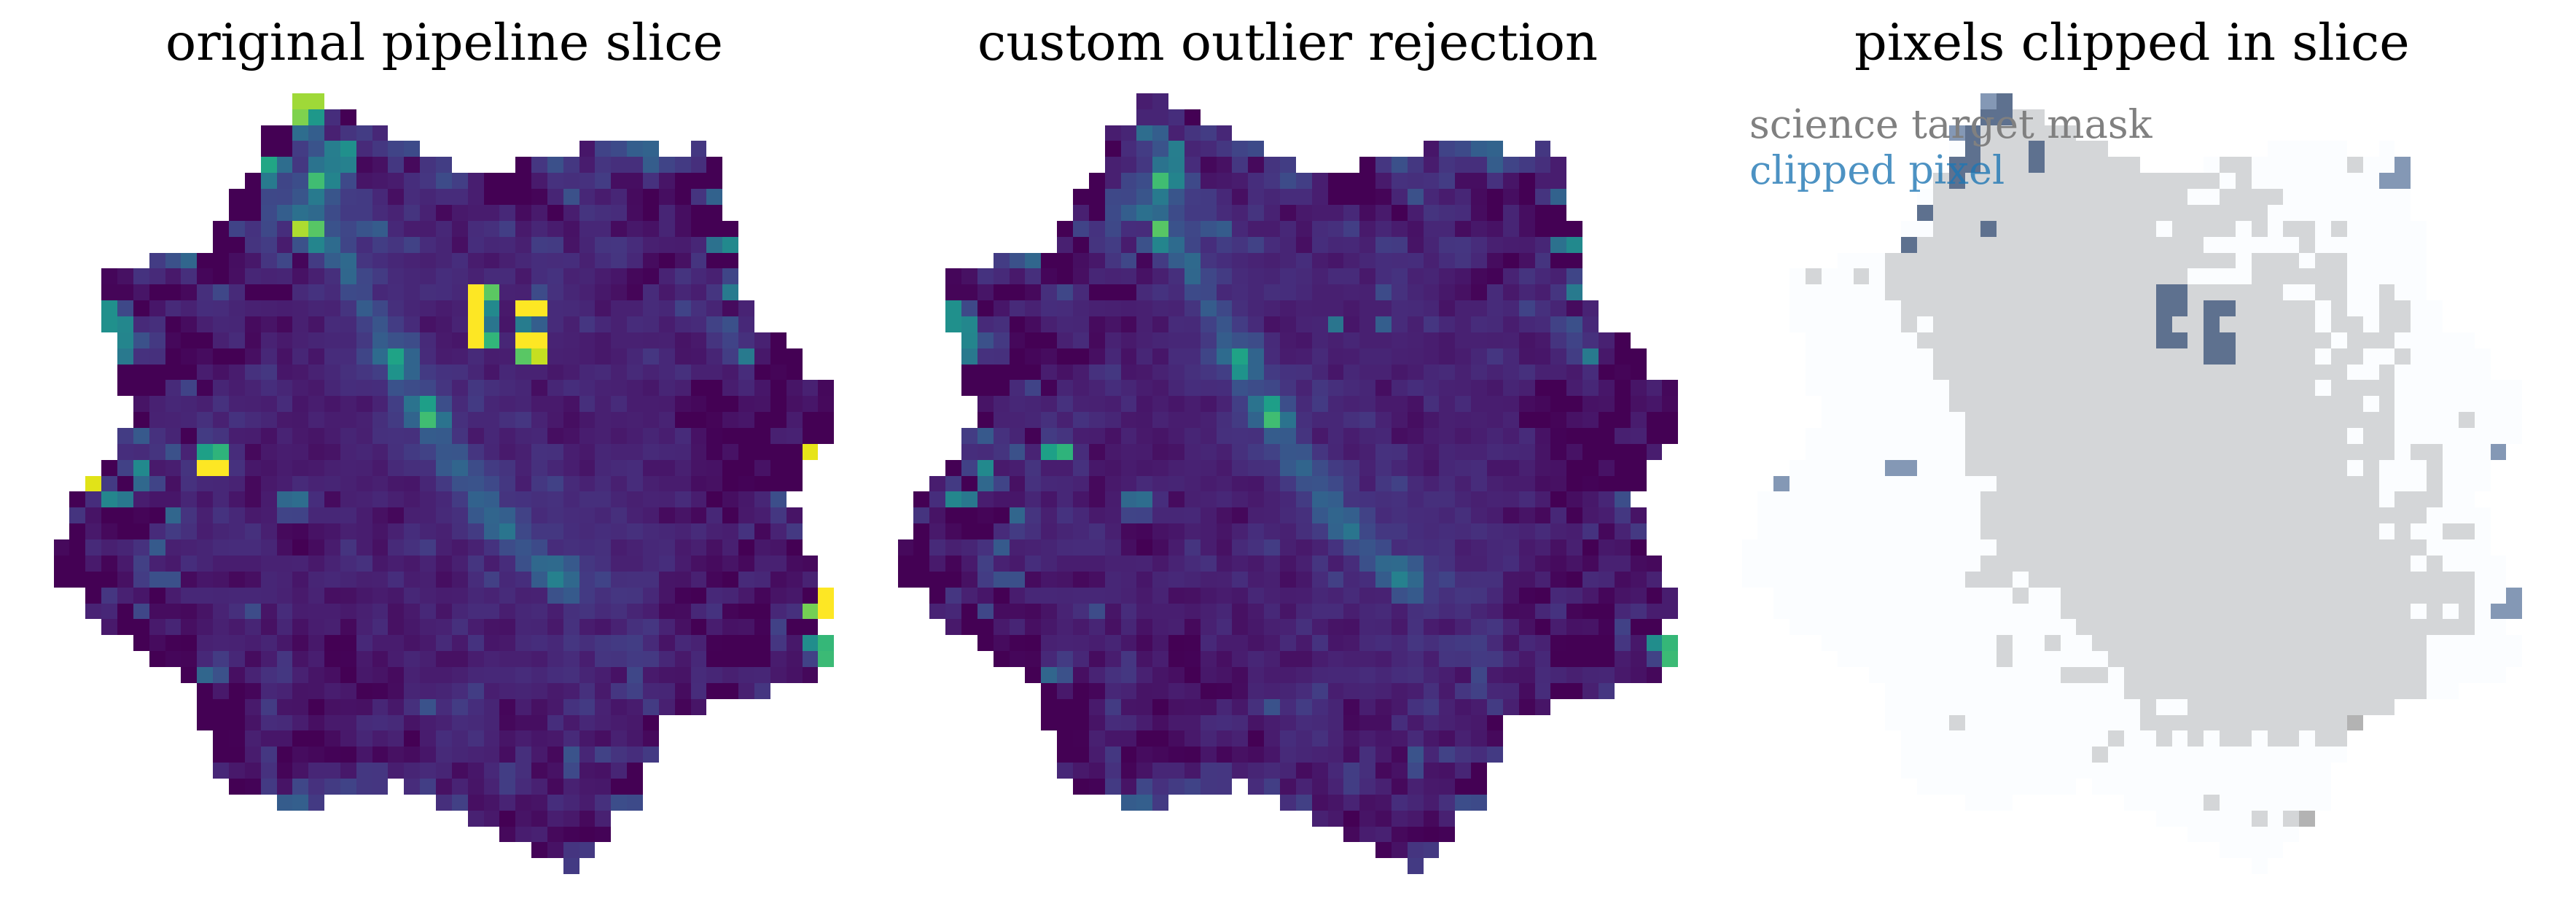

In [8]:

# plotting pieced together clipped slices
# -----------------------------------------

# defining the colormap limits here
clims = (-0.5,5)


plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(1,3,width_ratios=[1,1,1],wspace=0)


# original data cube straight from the pipeline
ax = plt.subplot(gs[0]); ax.axis('off')
ax.set_title('original pipeline slice')
ax.imshow(datacube[sli],clim=clims,origin='lower',
           cmap='viridis')


# slice from final sigma clipped cube
ax = plt.subplot(gs[1]); ax.axis('off')
ax.set_title('custom outlier rejection')
ax.imshow(final_clipped[sli],clim=clims,origin='lower',
           cmap='viridis')


# slice from clipping pixel tracker
ax = plt.subplot(gs[2]); ax.axis('off')
ax.set_title('pixels clipped in slice')
ax.imshow(full_mask,origin='lower',cmap='Greys',zorder=0,alpha=0.3)
ax.imshow(clipped_pixels[sli],origin='lower',cmap='Blues',alpha=0.5)
ax.text(0.047,0.927,'science target mask',color='grey',transform=ax.transAxes,fontsize=13)
ax.text(0.047,0.87,'clipped pixel',color='C0',transform=ax.transAxes,fontsize=13,alpha=0.8)


plt.tight_layout()
plt.show()
plt.close('all')


### Checking some basic stats

Below is some very basic stats-checking for the before & after clipping of the science target spaxels and the sky (i.e., NOT science target) spaxels for the benchmark slice.

In [9]:
# BEFORE & AFTER STATS
print('Stats for the science target spaxels, before & after clipping:',end='\n\n')
for d in [datacube[sli].copy(),final_clipped[sli].copy()]:
    d[full_mask<1] = np.nan
    print('Median:',np.nanmedian(d))
    print('Median Absolute Deviation:',stats.median_abs_deviation(d.flatten(),nan_policy='omit'))
    print('Max,Min:',np.nanmax(d),np.nanmin(d),end='\n\n')

    
print('Stats for the sky spaxels, before & after clipping:',end='\n\n')
for d in [datacube[sli].copy(),final_clipped[sli].copy()]:
    d[full_mask>0] = np.nan
    print('Median:',np.nanmedian(d))
    print('Median Absolute Deviation:',stats.median_abs_deviation(d.flatten(),nan_policy='omit'))
    print('Max,Min:',np.nanmax(d),np.nanmin(d),end='\n\n')

print()

Stats for the science target spaxels, before & after clipping:

Median: 0.08284913248011433
Median Absolute Deviation: 0.18139813840389252
Max,Min: 27.7409766936917 -7.722462770877391

Median: 0.06461730843970143
Median Absolute Deviation: 0.16671095043420792
Max,Min: 3.5738531375546154 -1.47723448031953

Stats for the sky spaxels, before & after clipping:

Median: -0.05868325882962383
Median Absolute Deviation: 0.26469574868679047
Max,Min: 26.76638067013213 -7.722462770877391

Median: -0.05868325882962383
Median Absolute Deviation: 0.25665976107120514
Max,Min: 3.258971335949391 -3.3447211956363025




### Saving outputs!

Let's save the final output from the algorithm!  The FITS file output will have the following extensions:
1. the data cube
2. the uncertainty array
3. the log of clipped/flagged pixels


For now, we're using a quick-and-dirty method to preserve the important header info -- copying the original header to these new cubes that we're saving and adding a comment.  This will be updated to a more accurate header in later versions.

In [10]:
header['comment'] = 'final clipped cube by H+ algorithm'

hdu = fits.PrimaryHDU(header=header)
hdu1 = fits.ImageHDU(final_clipped,header=header) # the data cube
hdu2 = fits.ImageHDU(final_clipped_error,header=header) # the error cube
hdu3 = fits.ImageHDU(clipped_pixels,header=header) # the clipped pixel tracker
hdul = fits.HDUList([hdu, hdu1, hdu2, hdu3])

hdul.writeto(f'plots-data/{target}-sigmaclipped-{grating}-s3d.fits',overwrite=True)


.  
.  
.  
### all doneee